In [1]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip install -q efficientnet

     |████████████████████████████████| 1.5 MB 883 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
import json
from tqdm import tqdm

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [4]:
size = [512,512]
n_classes = 5

path = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')
filenames = tf.io.gfile.glob(path + '/train_tfrecords/*.tfrec')
train_filenames = filenames[:-2]
valid_filenames = filenames[-2:]
test_filenames = tf.io.gfile.glob(path + '/test_tfrecords/*.tfrec')

In [5]:
with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    class_names = json.load(f)
class_names = {int(i): name for i, name in class_names.items()}
class_names

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [6]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
pd.value_counts(df['label'])

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [7]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_train = count_data_items(train_filenames)
n_val = count_data_items(valid_filenames)
n_test = count_data_items(test_filenames)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(n_train, n_val, n_test))

Dataset: 18732 training images, 2665 validation images, 1 unlabeled test images


In [ ]:
print('Dataset: {} images'.format(n_train + n_val + n_test))

In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.image.resize(image, size)
    return image


def read_labeled_tfrecord(example):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, image_feature_description)
    image = decode_image(example['image'])
    label = example['target']
    label = tf.one_hot(label,depth=5)
    label = tf.cast(label,tf.float32)
    return image, label


def read_unlabeled_tfrecord(example):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, image_feature_description)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=-1) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=-1)
    return dataset

In [9]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if np.random.random() > 0.75:
        image = tf.image.transpose(image)
        
    k = np.random.randint(0, 4)
    image = tf.image.rot90(image, k)
    
    if np.random.random() >= 0.4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if np.random.random() >= 0.4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if np.random.random() >= 0.4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    n = np.random.random()
    if n > 0.9:
        image = tf.image.central_crop(image, central_fraction=0.7)
    elif n > 0.8:
        image = tf.image.central_crop(image, central_fraction=0.8)
    elif n > 0.7:
        image = tf.image.central_crop(image, central_fraction=0.9)
    elif n > 0.4:
        crop_size = tf.random.uniform([], int(0.8*size[0]),size[0], dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    image = tf.image.resize(image, size)
    return image,label

def get_training_dataset():
    dataset = load_dataset(train_filenames, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=-1)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(valid_filenames, labeled=True, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(-1)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(test_filenames, labeled=False, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(-1)
    return dataset

In [10]:
batch_size = 32

train_ds = get_training_dataset()
valid_ds = get_validation_dataset()
test_ds = get_test_dataset()

In [11]:
for image, label in valid_ds.take(1):
    image_pack = image[20:24].numpy()
    label_pack = np.where(label[20:24].numpy() == 1)[1]

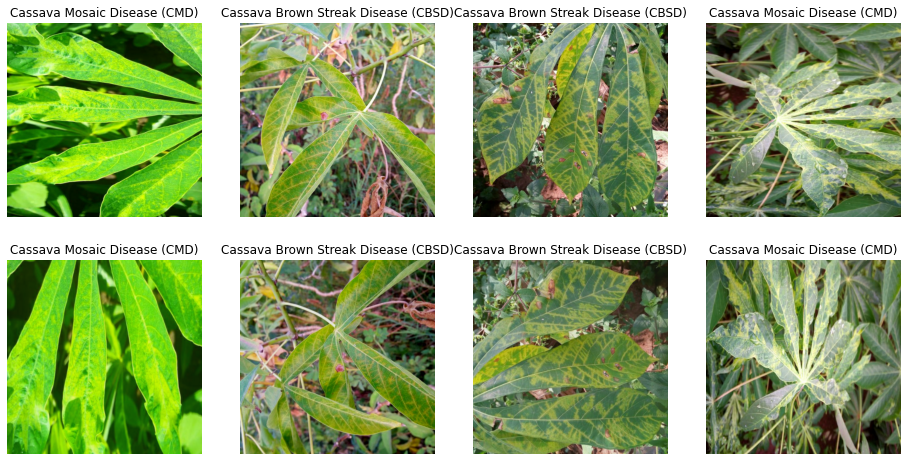

In [12]:
plt.figure(figsize=(16, 8))
for num, img in enumerate(image_pack):
    plt.subplot(2, 4, num + 1)
    plt.imshow(img)
    plt.title(class_names[label_pack[num]])
    plt.axis('off')
    plt.subplot(2, 4, num + 5)
    img, _ = data_augment(img, 0)
    plt.imshow(img)
    plt.title(class_names[label_pack[num]])
    plt.axis('off')

In [13]:
def create_model():
    model = tf.keras.Sequential([
        layers.Conv2D(16, 3, input_shape=(*size, 3)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(2),
        layers.Conv2D(32, 3),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(500),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.1),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

In [14]:
def compile_model(model):
    optimizer = tf.keras.optimizers.Adam(0.0001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [15]:
n_epochs = 10
steps_per_epoch = n_train//(batch_size)
tf.keras.backend.clear_session()
with strategy.scope():
    model = create_model()
    model = compile_model(model)
   
    history = model.fit(train_ds, 
                        epochs=n_epochs,
                        validation_data = valid_ds,
                        steps_per_epoch = steps_per_epoch
                       )

Epoch 1/10
585/585 [==============================] - 66s 112ms/step - categorical_accuracy: 0.5837 - loss: 1.1756 - val_categorical_accuracy: 0.6326 - val_loss: 1.0888
Epoch 2/10
585/585 [==============================] - 56s 96ms/step - categorical_accuracy: 0.6240 - loss: 1.0573 - val_categorical_accuracy: 0.6281 - val_loss: 1.0611
Epoch 3/10
585/585 [==============================] - 58s 99ms/step - categorical_accuracy: 0.6315 - loss: 1.0350 - val_categorical_accuracy: 0.6398 - val_loss: 1.0112
Epoch 4/10
585/585 [==============================] - 58s 99ms/step - categorical_accuracy: 0.6358 - loss: 1.0151 - val_categorical_accuracy: 0.6495 - val_loss: 0.9988
Epoch 5/10
585/585 [==============================] - 58s 98ms/step - categorical_accuracy: 0.6381 - loss: 1.0018 - val_categorical_accuracy: 0.5223 - val_loss: 1.1205
Epoch 6/10
585/585 [==============================] - 59s 101ms/step - categorical_accuracy: 0.6431 - loss: 0.9827 - val_categorical_accuracy: 0.6255 - val_los

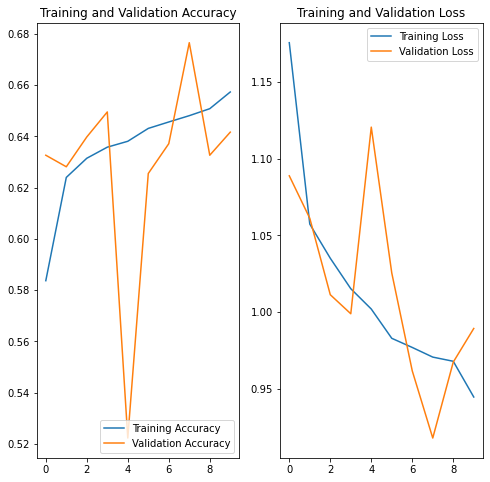

In [16]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
def create_model():
    base_model =  efn.EfficientNetB7(
        include_top=False,
        input_shape=[*size, 3],
        pooling='max'
    )
    
    inputs = tf.keras.Input(shape=(*size, 3))
    x = base_model(inputs)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [21]:
def compile_model(model):
    optimizer = tf.keras.optimizers.Adam(0.0001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [22]:
n_epochs = 10
steps_per_epoch = n_train//(batch_size)

tf.keras.backend.clear_session()
with strategy.scope():
    model = create_model()
    model = compile_model(model)
    
    history = model.fit(train_ds, 
                        epochs=n_epochs,
                        validation_data = valid_ds,
                        steps_per_epoch = steps_per_epoch
                       )

258441216/258434480 [==============================] - 9s 0us/step
Epoch 1/10
585/585 [==============================] - 315s 539ms/step - categorical_accuracy: 0.6667 - loss: 1.0765 - val_categorical_accuracy: 0.8180 - val_loss: 0.5184
Epoch 2/10
585/585 [==============================] - 266s 454ms/step - categorical_accuracy: 0.7839 - loss: 0.6388 - val_categorical_accuracy: 0.8567 - val_loss: 0.4221
Epoch 3/10
585/585 [==============================] - 265s 453ms/step - categorical_accuracy: 0.8177 - loss: 0.5436 - val_categorical_accuracy: 0.8642 - val_loss: 0.3965
Epoch 4/10
585/585 [==============================] - 265s 453ms/step - categorical_accuracy: 0.8364 - loss: 0.4841 - val_categorical_accuracy: 0.8732 - val_loss: 0.3702
Epoch 5/10
585/585 [==============================] - 266s 455ms/step - categorical_accuracy: 0.8513 - loss: 0.4470 - val_categorical_accuracy: 0.8777 - val_loss: 0.3699
Epoch 6/10
585/585 [==============================] - 266s 455ms/step - categorical

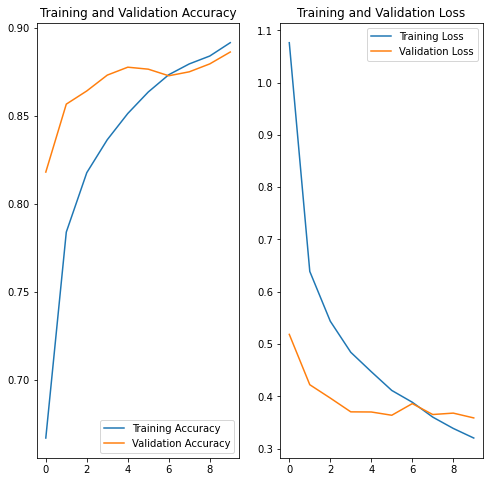

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
model.save('trained_model.h5', save_format='h5')

In [25]:
model = tf.keras.models.load_model('trained_model.h5')